In [1]:
from tiled.client import from_uri
import importlib
import numpy as np
import matplotlib.pyplot as plt
c = from_uri("http://tld:8000")

In [2]:
def find_latest():
    keys= list(c.keys())
    for key in keys[::-1]:
        if "tell" in c[key]:
            return c[key]

## Grab A Run

In [3]:
run = find_latest()

In [4]:
run.metadata

{'start': {'agent_name': 'ActiveKMeans-litter-walk',
           'model_params': {'algorithm': 'lloyd',
                            'copy_x': True,
                            'init': 'k-means++',
                            'max_iter': 300,
                            'n_clusters': 3,
                            'n_init': 'auto',
                            'random_state': None,
                            'tol': 0.0001,
                            'verbose': 0},
           'model_type': 'KMeans',
           'motor_names': ['wafer_x', 'wafer_y'],
           'motor_resolution': 0.1,
           'time': 1719162350.2816348,
           'uid': '78b1652d-6292-437b-b1b1-be31fac8dfed'},
 'stop': None,
 'summary': {'datetime': datetime.datetime(2024, 6, 23, 17, 5, 50, 281635, tzinfo=datetime.timezone.utc),
             'duration': None,
             'plan_name': None,
             'scan_id': None,
             'stream_names': ['ask', 'report', 'tell'],
             'timestamp': 1719162350.281634

In [5]:
run

<Container {'ask', 'report', 'tell'}>

In [6]:
run['ask']['data']

<DatasetClient ['time', 'suggestion', 'cluster_centers', 'cache_len', 'latest_data', 'requested_batch_size', 'redundant_points_discarded', 'absolute_position_offset', 'batch_idx', 'batch_size']>

In [7]:
run['report']['data']

<DatasetClient ['time', 'cluster_centers', 'cache_len', 'latest_data']>

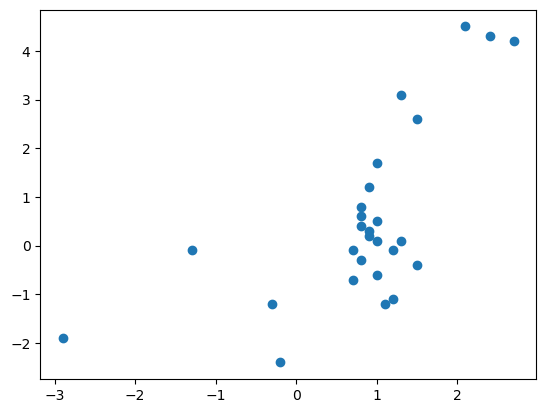

In [8]:
plt.scatter(*run['ask']['data']['suggestion'].read().T)

In [9]:
run['ask']['data']['cluster_centers'][-1]

array([[6.17641388e-05, 3.16242476e-05, 2.00909127e-05, ...,
        3.15805971e-04, 2.61277059e-04, 2.03247551e-04],
       [2.20478741e-04, 2.29073885e-04, 3.31117452e-04, ...,
        9.08109043e-04, 7.23876568e-04, 5.34234936e-04],
       [1.05604582e-03, 8.77067985e-04, 9.54675172e-04, ...,
        1.72043248e-03, 1.33196916e-03, 9.44325474e-04]])

## That plot wasn't SUPER informative. But we can remodel everything from a report.

In [10]:
def remodel_from_report(run, idx: int = None):
        """Grabs specified (or most recent) report document and rebuilds modelling of dataset at that point.

        This enables fixed dimension reports that can be stacked and compared, while also allowing for
        deep inspection at the time of a report.

        Parameters
        ----------
        run : BlueskyRun
            Agent Run
        idx : int, optional
            Report index, by default most recent

        Returns
        -------
        model : SklearnEstimatorAgentBase
        data : dict
            Dictionary of model components, weights, independent_vars, and observables
        """
        module_ = importlib.import_module("sklearn.cluster")
        model = getattr(module_, run.metadata['start']["model_type"])().set_params(**run.metadata['start']["model_params"])
        idx = -1 if idx is None else idx
        model.cluster_centers_ = run['report']["data"]["cluster_centers"][idx]
        latest_uid = run['report']["data"]["latest_data"][idx]
        tell_idx = np.where(run['tell']["data"]["exp_uid"].read() == latest_uid)[0][-1]
        
        independents =  run['tell']["data"]["independent_variable"][:tell_idx]
        observables = run['tell']["data"]["observable"][:tell_idx]
        arr = observables

        try:
            clusters = model.predict(arr)
            distances = model.transform(arr)
        except AttributeError:
            model.fit(arr)
            model.cluster_centers_ = run['report']["data"]["cluster_centers"][idx]
            clusters = model.predict(arr)
            distances = model.transform(arr)
        return model, dict(
            clusters=clusters,
            distances=distances,
            cluster_centers=model.cluster_centers_,
            independent_vars=independents,
            observables=observables,
        )

In [11]:
model, data_dict = remodel_from_report(run)

In [12]:
data_dict.keys()

dict_keys(['clusters', 'distances', 'cluster_centers', 'independent_vars', 'observables'])

In [13]:
def make_plot(data_dict):
    independent_vars = data_dict["independent_vars"]  # This should be an array with shape (m, 2)
    clusters = data_dict["clusters"]  # This should be an array with shape (m,)
    fig = plt.figure(figsize=(8, 6))
    scatter = plt.scatter(independent_vars[:, 0], independent_vars[:, 1], c=clusters, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Cluster')
    plt.title('2D Plot of Independent Variables by Cluster')
    plt.xlabel('Independent Var 1')
    plt.ylabel('Independent Var 2')
    return fig

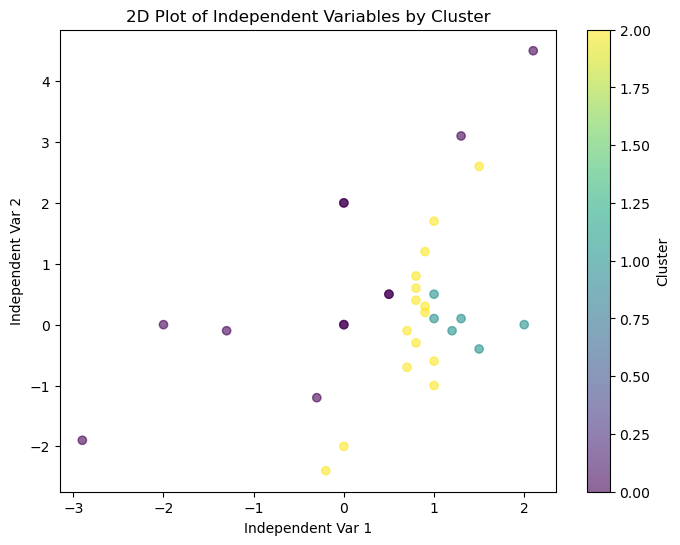

In [14]:
fig = make_plot(data_dict)

In [15]:
data_dict["independent_vars"].shape

(33, 2)